# GloVE

Let's work on implementation of GloVE.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time, re, os, math
from collections import Counter
from itertools import combinations_with_replacement

In [6]:
print("numpy:", np.__version__)
print("torch:", torch.__version__)

numpy: 2.4.1
torch: 2.9.1+cpu


## 1. Load data

In [8]:
import nltk
nltk.download("brown")
from nltk.corpus import brown

def load_news_corpus(max_sentences=20000):
    sents = brown.sents(categories="news")[:max_sentences]
    corpus = []
    for sent in sents:
        toks = [w.lower() for w in sent]
        toks = [w for w in toks if re.fullmatch(r"[a-z]+", w)]
        if len(toks) >= 2:
            corpus.append(toks)
    return corpus

corpus = load_news_corpus(max_sentences=20000)
print("num sentences:", len(corpus))
print("example:", corpus[0][:20])

num sentences: 4555
example: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took']


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## 2. Build Vocabulary + Mapping

In [9]:
flatten = lambda l: [item for sublist in l for item in sublist]

def build_vocab(corpus, min_count=5, max_vocab=30000):
    counts = Counter(flatten(corpus))
    items = [(w,c) for w,c in counts.items() if c >= min_count]
    items.sort(key=lambda x: x[1], reverse=True)
    items = items[:max_vocab]

    vocab = [w for w,_ in items]
    vocab.append("<UNK>")

    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for w,i in word2index.items()}
    return vocab, word2index, index2word, counts

vocab, word2index, index2word, word_counts = build_vocab(corpus, min_count=5, max_vocab=30000)
voc_size = len(vocab)

print("voc_size:", voc_size)
print("top10:", vocab[:10])
print("UNK index:", word2index["<UNK>"])

voc_size: 2373
top10: ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'that', 'is', 'was']
UNK index: 2372


In [10]:
def build_skipgrams(corpus, window_size=2):
    skip_grams = []
    for doc in corpus:
        for i in range(len(doc)):
            center = doc[i]
            left = max(0, i - window_size)
            right = min(len(doc), i + window_size + 1)
            for j in range(left, right):
                if j == i:
                    continue
                skip_grams.append((center, doc[j]))
    return skip_grams

window_size = 2
skip_grams = build_skipgrams(corpus, window_size=window_size)
print("num skip_grams:", len(skip_grams), "sample:", skip_grams[:5])

num skip_grams: 306722 sample: [('the', 'fulton'), ('the', 'county'), ('fulton', 'the'), ('fulton', 'county'), ('fulton', 'grand')]


In [11]:
X_ik_skipgrams = Counter(skip_grams)

def weighting(w_i, w_j, X_ik, x_max=100, alpha=0.75):
    x_ij = X_ik.get((w_i, w_j), 1.0)
    return (x_ij / x_max) ** alpha if x_ij < x_max else 1.0

X_ik = {}
weighting_dic = {}
for (wi, wj), co in X_ik_skipgrams.items():
    X_ik[(wi, wj)] = float(co) + 1.0
    weighting_dic[(wi, wj)] = weighting(wi, wj, X_ik)

print("X_ik size:", len(X_ik), "weighting_dic size:", len(weighting_dic))

X_ik size: 184462 weighting_dic size: 184462


## 3. Prepare train data

In [12]:
import math

def random_batch_glove(batch_size, skip_grams, X_ik, weighting_dic, word2index):
    unk = word2index["<UNK>"]

    # convert skip_grams to ids once per call (simple + readable)
    skip_grams_id = [(word2index.get(a, unk), word2index.get(b, unk)) for a, b in skip_grams]

    rand_idx = np.random.choice(len(skip_grams_id), batch_size, replace=False)

    inputs, labels, coocs, weightings = [], [], [], []
    for idx in rand_idx:
        ci, oj = skip_grams_id[idx]
        inputs.append([ci])
        labels.append([oj])

        pair = skip_grams[idx]  # (word_i, word_j)

        x_ij = X_ik.get(pair, 1.0)                 # stability
        coocs.append([math.log(x_ij)])             # log co-occurrence

        w_ij = weighting_dic.get(pair, 1.0)        # f(x_ij)
        weightings.append([w_ij])

    return (np.array(inputs, dtype=np.int64),
            np.array(labels, dtype=np.int64),
            np.array(coocs, dtype=np.float32),
            np.array(weightings, dtype=np.float32))

# test
batch_size = 10
x, y, cooc, weighting = random_batch_glove(batch_size, skip_grams, X_ik, weighting_dic, word2index)
print(x.shape, y.shape, cooc.shape, weighting.shape)
print(x[:3].T, y[:3].T, cooc[:3].T, weighting[:3].T)

(10, 1) (10, 1) (10, 1) (10, 1)
[[  3 123 597]] [[1790    6   81]] [[1.0986123 1.609438  0.6931472]] [[0.07208434 0.10573713 0.05318296]]


## 4. Model

In [13]:
class Glove(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.center_embedding = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)

        self.center_bias = nn.Embedding(voc_size, 1)
        self.outside_bias = nn.Embedding(voc_size, 1)

    def forward(self, center, outside, coocs, weighting):

        v_i = self.center_embedding(center)                 # (B,1,E)
        v_j = self.outside_embedding(outside)               # (B,1,E)

        b_i = self.center_bias(center).squeeze(1)           # (B,1)
        b_j = self.outside_bias(outside).squeeze(1)         # (B,1)

        inner = v_j.bmm(v_i.transpose(1, 2)).squeeze(2)     # (B,1)
        loss = weighting * torch.pow(inner + b_i + b_j - coocs, 2)

        return torch.sum(loss)  # scalar

# quick test
voc_size = len(vocab)
emb_size = 100
model = Glove(voc_size, emb_size)

x_t = torch.LongTensor(x)
y_t = torch.LongTensor(y)
cooc_t = torch.FloatTensor(cooc)
w_t = torch.FloatTensor(weighting)

loss = model(x_t, y_t, cooc_t, w_t)
print("test loss:", loss.item())

test loss: 119.92762756347656


## 5. Training

In [15]:
batch_size = 512
embedding_size = 100
lr = 0.001
num_epochs = 10000

model = Glove(voc_size, embedding_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_history = []
start_train = time.time()

for epoch in range(num_epochs):
    xb, yb, coocb, wb = random_batch_glove(batch_size, skip_grams, X_ik, weighting_dic, word2index)

    xb = torch.LongTensor(xb)
    yb = torch.LongTensor(yb)
    coocb = torch.FloatTensor(coocb)
    wb = torch.FloatTensor(wb)

    optimizer.zero_grad()
    loss = model(xb, yb, coocb, wb)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | loss: {loss.item():.6f}")

train_time = time.time() - start_train
print("Training time (sec):", train_time)

Epoch 500/10000 | loss: 3153.909668
Epoch 1000/10000 | loss: 1675.761230
Epoch 1500/10000 | loss: 1093.535767
Epoch 2000/10000 | loss: 963.128235
Epoch 2500/10000 | loss: 667.485596
Epoch 3000/10000 | loss: 572.508057
Epoch 3500/10000 | loss: 490.294556
Epoch 4000/10000 | loss: 390.169800
Epoch 4500/10000 | loss: 265.599274
Epoch 5000/10000 | loss: 292.599548
Epoch 5500/10000 | loss: 167.641296
Epoch 6000/10000 | loss: 175.411743
Epoch 6500/10000 | loss: 134.284058
Epoch 7000/10000 | loss: 135.506805
Epoch 7500/10000 | loss: 95.262222
Epoch 8000/10000 | loss: 106.751686
Epoch 8500/10000 | loss: 81.871132
Epoch 9000/10000 | loss: 43.820461
Epoch 9500/10000 | loss: 46.096542
Epoch 10000/10000 | loss: 35.415779
Training time (sec): 731.2231628894806


## 6. Plotting

PCA variance ratio: [0.05378708 0.05093019]


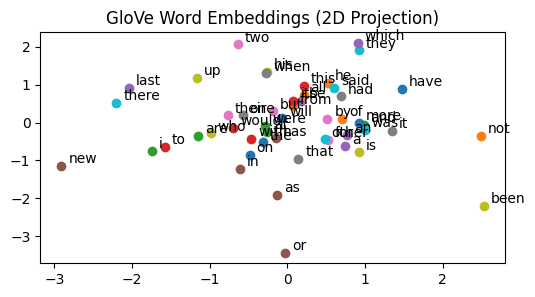

In [20]:
#Embeddings
from sklearn.decomposition import PCA

def get_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model.center_embedding(idx_t)
    u = model.outside_embedding(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

# collect embeddings for plotting
words_to_plot = vocab[:50]
embs = np.array([get_embed(w) for w in words_to_plot])

# reduce to 2D if needed
if embs.shape[1] != 2:
    pca = PCA(n_components=2)
    embs_2d = pca.fit_transform(embs)
    print("PCA variance ratio:", pca.explained_variance_ratio_)
else:
    embs_2d = embs

# plot
plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("GloVe Word Embeddings (2D Projection)")
plt.show()


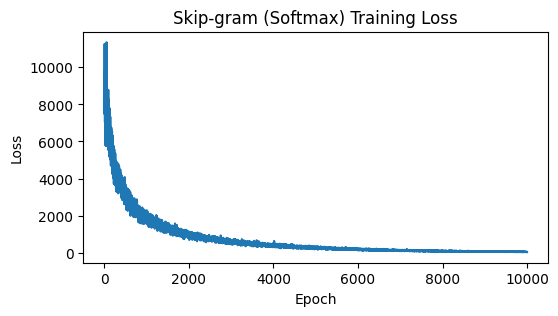

In [21]:
#Loss
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.title("Skip-gram (Softmax) Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 7. Cosine similarity

In [18]:
def cosine(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12))

def get_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model.center_embedding(idx_t)
    u = model.outside_embedding(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

print("cat vs fruit:", cosine(get_embed("cat"), get_embed("fruit")))
print("cat vs animal:", cosine(get_embed("cat"), get_embed("animal")))
print("cat vs cat:", cosine(get_embed("cat"), get_embed("cat")))


cat vs fruit: 1.0
cat vs animal: 1.0
cat vs cat: 1.0
